In [20]:
from google.colab import drive
drive.mount("/content/drive")

import os, sys, time, csv
import numpy as np
import torch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
ROOT = "/content/drive/MyDrive/HiCForecast_Project_experiment_3/HiCForecast"
assert os.path.exists(ROOT), f"Missing ROOT: {ROOT}"

sys.path.insert(0, ROOT)
os.chdir(ROOT)

print("ROOT:", ROOT)
print("CUDA:", torch.cuda.is_available())


ROOT: /content/drive/MyDrive/HiCForecast_Project_experiment_3/HiCForecast
CUDA: True


In [22]:
loss_path = f"{ROOT}/loss/structure_loss.py"
os.makedirs(os.path.dirname(loss_path), exist_ok=True)

code = '''import torch
import torch.nn.functional as F

def insulation_vector(mat: torch.Tensor, w: int = 4, eps: float = 1e-6):
    if mat.dim() == 4:
        mat = mat[:, 0]  # (B,N,N)

    B, N, _ = mat.shape
    mat = torch.relu(mat)

    vals = []
    for i in range(w, N - w):
        block = mat[:, i-w:i, i:i+w]   # (B,w,w)
        vals.append(block.sum(dim=(1,2)))
    v = torch.stack(vals, dim=1)       # (B, N-2w)
    v = torch.log(v + eps)
    return v

def tad_insulation_loss(pred: torch.Tensor, gt: torch.Tensor, w: int = 4):
    p = insulation_vector(pred, w=w)
    g = insulation_vector(gt, w=w)

    p = (p - p.mean(dim=1, keepdim=True)) / (p.std(dim=1, keepdim=True) + 1e-6)
    g = (g - g.mean(dim=1, keepdim=True)) / (g.std(dim=1, keepdim=True) + 1e-6)
    return F.l1_loss(p, g)

def peak_weighted_l1(pred: torch.Tensor, gt: torch.Tensor, gamma: float = 2.0, clamp_max: float = 10.0, eps: float = 1e-6):
    pred2 = pred[:,0] if pred.dim() == 4 else pred
    gt2   = gt[:,0] if gt.dim() == 4 else gt

    gt_mean = gt2.mean(dim=(1,2), keepdim=True)
    w = (gt2 / (gt_mean + eps)).clamp(min=0.0)
    w = torch.pow(w, gamma).clamp(max=clamp_max)
    return (w * (pred2 - gt2).abs()).mean()
'''

with open(loss_path, "w") as f:
    f.write(code)

init_path = f"{ROOT}/loss/__init__.py"
if not os.path.exists(init_path):
    open(init_path, "w").write("# loss package\n")

print("Wrote:", loss_path)

Wrote: /content/drive/MyDrive/HiCForecast_Project_experiment_3/HiCForecast/loss/structure_loss.py


In [ ]:
# Ground truth
GT_PATH = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty/gt_chr19.npy"

# Predictions
BASELINE_PRED = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729/pred_baseline.npy"   # <-- 
UNC_MEAN_PRED = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty/pred_uncertainty_mean.npy"
GRAPH_PRED    = "/content/drive/MyDrive/HiCForecast_Project_experiment_2/pred_graphdiff.npy"

print("GT:", GT_PATH)
print("Baseline pred:", BASELINE_PRED)
print("Unc mean pred:", UNC_MEAN_PRED)
print("Graph pred:", GRAPH_PRED)

GT: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty/gt_chr19.npy
Baseline pred: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729/pred_baseline.npy
Unc mean pred: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty/pred_uncertainty_mean.npy
Graph pred: /content/drive/MyDrive/HiCForecast_Project_experiment_2/pred_graphdiff.npy


In [24]:
from loss.structure_loss import tad_insulation_loss, peak_weighted_l1

gt = np.load(GT_PATH).astype(np.float32)  # (T,N,N)
fixed = [2, 5, 5]

def eval_structure(pred_path, tag):
    pred = np.load(pred_path).astype(np.float32)  # (3,N,N)
    rows = []
    for i in range(3):
        t = fixed[i]

        pred_t = torch.from_numpy(pred[i:i+1]).unsqueeze(1)  # (1,1,N,N)
        gt_t   = torch.from_numpy(gt[t:t+1]).unsqueeze(1)

        ltad = float(tad_insulation_loss(pred_t, gt_t, w=4))
        lpk  = float(peak_weighted_l1(pred_t, gt_t, gamma=2.0))

        rows.append({
            "model": tag,
            "pred_idx": i,
            "gt_idx": t,
            "tad_insulation_loss": ltad,
            "peak_weighted_l1": lpk
        })
    return rows

all_rows = []
all_rows += eval_structure(BASELINE_PRED, "baseline")
all_rows += eval_structure(UNC_MEAN_PRED, "uncertainty_mean")
all_rows += eval_structure(GRAPH_PRED, "graph_diffusion")

for r in all_rows:
    print(r)

{'model': 'baseline', 'pred_idx': 0, 'gt_idx': 2, 'tad_insulation_loss': 0.04016532748937607, 'peak_weighted_l1': 4.0789265632629395}
{'model': 'baseline', 'pred_idx': 1, 'gt_idx': 5, 'tad_insulation_loss': 0.05138135701417923, 'peak_weighted_l1': 5.705303192138672}
{'model': 'baseline', 'pred_idx': 2, 'gt_idx': 5, 'tad_insulation_loss': 0.04915013536810875, 'peak_weighted_l1': 5.612513542175293}
{'model': 'uncertainty_mean', 'pred_idx': 0, 'gt_idx': 2, 'tad_insulation_loss': 0.04016534611582756, 'peak_weighted_l1': 4.0789265632629395}
{'model': 'uncertainty_mean', 'pred_idx': 1, 'gt_idx': 5, 'tad_insulation_loss': 0.05138135701417923, 'peak_weighted_l1': 5.705303192138672}
{'model': 'uncertainty_mean', 'pred_idx': 2, 'gt_idx': 5, 'tad_insulation_loss': 0.049150142818689346, 'peak_weighted_l1': 5.612513542175293}
{'model': 'graph_diffusion', 'pred_idx': 0, 'gt_idx': 2, 'tad_insulation_loss': 0.050992202013731, 'peak_weighted_l1': 7.411793231964111}
{'model': 'graph_diffusion', 'pred_id

In [25]:
OUT_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_3/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

run_id = time.strftime("%Y%m%d_%H%M%S")
out_csv = f"{OUT_DIR}/{run_id}_experiment3_structure_metrics.csv"

with open(out_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(all_rows[0].keys()))
    w.writeheader()
    w.writerows(all_rows)

print("Saved:", out_csv)

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_3/outputs/20260119_032250_experiment3_structure_metrics.csv


# **summary table**

In [26]:
import pandas as pd

df = pd.DataFrame(all_rows)
print(df)

summary = df.groupby("model")[["tad_insulation_loss","peak_weighted_l1"]].mean().reset_index()
summary = summary.sort_values("tad_insulation_loss")  # or peak_weighted_l1
print("\n=== Summary (mean over 3 preds) ===")
print(summary)

              model  pred_idx  gt_idx  tad_insulation_loss  peak_weighted_l1
0          baseline         0       2             0.040165          4.078927
1          baseline         1       5             0.051381          5.705303
2          baseline         2       5             0.049150          5.612514
3  uncertainty_mean         0       2             0.040165          4.078927
4  uncertainty_mean         1       5             0.051381          5.705303
5  uncertainty_mean         2       5             0.049150          5.612514
6   graph_diffusion         0       2             0.050992          7.411793
7   graph_diffusion         1       5             0.063200          6.992376
8   graph_diffusion         2       5             0.063890          7.214933

=== Summary (mean over 3 preds) ===
              model  tad_insulation_loss  peak_weighted_l1
0          baseline             0.046899          5.132248
2  uncertainty_mean             0.046899          5.132248
1   graph_diffus

In [27]:
summary.to_csv(f"{OUT_DIR}/{run_id}_experiment3_structure_metrics_summary.csv", index=False)
print("Saved summary CSV")

Saved summary CSV


# **insulation profile plot**

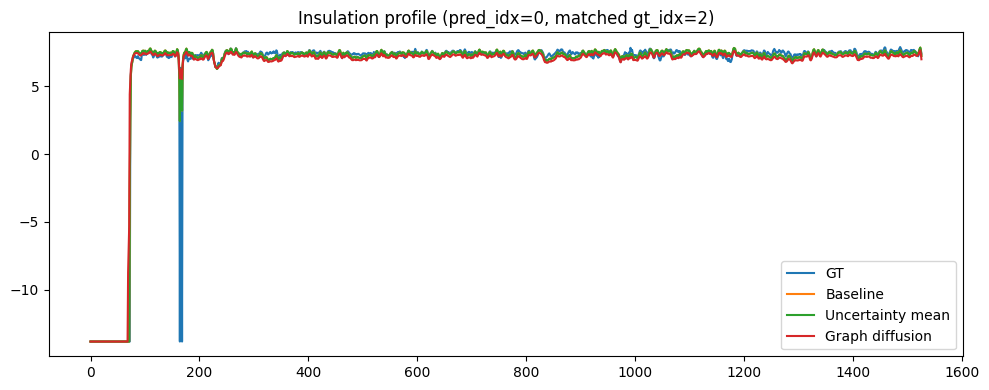

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_3/outputs/20260119_032250_fig_insulation_pred0_gt2.png


In [28]:
import matplotlib.pyplot as plt
from loss.structure_loss import insulation_vector

# pick which prediction horizon to show
pred_idx = 0
gt_idx = fixed[pred_idx]

# load arrays
gt_mat = torch.from_numpy(gt[gt_idx:gt_idx+1]).unsqueeze(1)  # (1,1,N,N)

pred_baseline = torch.from_numpy(np.load(BASELINE_PRED)[pred_idx:pred_idx+1]).unsqueeze(1)
pred_uncmean  = torch.from_numpy(np.load(UNC_MEAN_PRED)[pred_idx:pred_idx+1]).unsqueeze(1)
pred_graph    = torch.from_numpy(np.load(GRAPH_PRED)[pred_idx:pred_idx+1]).unsqueeze(1)

# compute insulation vectors
g = insulation_vector(gt_mat, w=4).squeeze(0).numpy()
b = insulation_vector(pred_baseline, w=4).squeeze(0).numpy()
u = insulation_vector(pred_uncmean, w=4).squeeze(0).numpy()
r = insulation_vector(pred_graph, w=4).squeeze(0).numpy()

plt.figure(figsize=(10,4))
plt.plot(g, label="GT")
plt.plot(b, label="Baseline")
plt.plot(u, label="Uncertainty mean")
plt.plot(r, label="Graph diffusion")
plt.title(f"Insulation profile (pred_idx={pred_idx}, matched gt_idx={gt_idx})")
plt.legend()
plt.tight_layout()

fig_path = f"{OUT_DIR}/{run_id}_fig_insulation_pred{pred_idx}_gt{gt_idx}.png"
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)